In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata


In [32]:
def nencioli(u, v, lon, lat, a, b):
    """
    Identify the points in the domain which satisfy the four velocity constraints for eddy detection.

    Parameters:
    - u, v: 2D velocity fields for u and v components
    - lon, lat: Longitude and Latitude matrices
    - mask: Matrix defining sea (1) and land points (0)
    - a, b: Parameters used for constraints

    Returns:
    - eddy_uv: Positions that satisfy the first two constraints (for debugging)
    - eddy_c: Positions satisfying the first three constraints (for debugging)
    - eddy: Positions of the eddy centers with their type (cyclonic=1, anticyclonic=-1)
    """

    borders = max(a, b) + 1

    # Compute velocity magnitude
    vel = np.sqrt(u**2 + v**2)

    # Initialize arrays for storing eddy centers
    eddy_uv = np.zeros((0, 2))
    eddy_c = np.zeros((0, 2))
    eddy = np.zeros((0, 3))

    # Get domain dimensions
    bound = vel.shape

    # Loop through each latitudinal section
    for i in range(borders, len(v) - borders + 1):
        wrk = v[i, :]  # Latitudinal section of v

        # First constraint: zero crossing in v component
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        indx = indx[(indx >= borders) & (indx < len(wrk) - borders)]

        for ii in indx:
            var = 0  # Eddy type (0 = no eddy, 1 = cyclonic, -1 = anticyclonic)
            if wrk[ii] >= 0:  # Anticyclonic
                if wrk[ii - a] > wrk[ii] and wrk[ii + 1 + a] < wrk[ii + 1]:
                    var = -1
            elif wrk[ii] < 0:  # Cyclonic
                if wrk[ii - a] < wrk[ii] and wrk[ii + 1 + a] > wrk[ii + 1]:
                    var = 1

            # Second constraint: u component reversal
            if var != 0:
                if var == -1:
                    if (u[i - a, ii] <= 0 and u[i - a, ii] <= u[i - 1, ii] and
                        u[i + a, ii] >= 0 and u[i + a, ii] >= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                elif var == 1:
                    if (u[i - a, ii] >= 0 and u[i - a, ii] >= u[i - 1, ii] and
                        u[i + a, ii] <= 0 and u[i + a, ii] <= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0

                # Third constraint: velocity minimum
                if var != 0:
                    srch = vel[i - b:i + b, ii - b:ii + b + 1]
                    slat = lat[i - b:i + b, ii - b:ii + b + 1]
                    slon = lon[i - b:i + b, ii - b:ii + b + 1]
                    X, Y = np.unravel_index(np.argmin(srch), srch.shape)
                    srch2 = vel[max(i - b + X - 1 - b, 0):min(i - b + X - 1 + b, bound[0]),
                                max(ii - b + Y - 1 - b, 0):min(ii - b + Y - 1 + b, bound[1])]

                    if np.min(srch2) == np.min(srch):
                        eddy_c = np.vstack([eddy_c, [slat[X, Y], slon[X, Y]]])
                    else:
                        var = 0

                # Fourth constraint: vector rotation (simplified version)
                d = a - 1
                if var != 0:
                    # Find indices of the estimated center in the large domain
                    i1, i2 = np.where((lat == slat[X, Y]) & (lon == slon[X, Y]))

                    i1, i2 = int(i1[0]), int(i2[0])
                    
                    # Extract velocities within "a-1" points from the estimated center
                    u_small = u[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    v_small = v[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    
                    # Apply constraint only if there are no NaNs in u_small
                    if not np.isnan(u_small).any():
                        # Boundary velocities
                        u_bound = np.concatenate([u_small[0, :], u_small[1:, -1], u_small[-1, -2::-1], u_small[-2::-1, 0]])
                        v_bound = np.concatenate([v_small[0, :], v_small[1:, -1], v_small[-1, -2::-1], v_small[-2::-1, 0]])

                        # Vector defining which quadrant each boundary vector belongs to
                        quadrants = np.zeros_like(u_bound)
                        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
                        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
                        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
                        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4
                        
                        # Identify the first fourth quadrant vector
                        spin = np.where(quadrants == 4)[0]
                        
                        # Apply the constraint only if the rotation is complete and not all vectors are in the fourth quadrant
                        if spin.size > 0 and spin.size != quadrants.size:
                            # If vectors start in the 4th quadrant, add 4 to all quadrant positions after the first occurrence
                            if spin[0] == 0:
                                spin = np.where(quadrants != 4)[0]
                                spin = spin[0] - 1
                                
                            if not isinstance(spin, np.ndarray):
                                spin = np.array([int(spin)])
                            quadrants[spin[-1] + 1:] += 4
                            
                            # Inspect vector rotation: no consecutive vectors should be more than one quadrant apart
                            # and there should be no backward rotation
                            if not np.any(np.diff(quadrants) > 1) and not np.any(np.diff(quadrants) < 0):
                                eddy = np.vstack([eddy, [slat[X, Y], slon[X, Y], var]])


    # Process eddy results (sorting and removing duplicates)
    eddy = np.unique(eddy, axis=0)
    eddy_uv = np.unique(eddy_uv, axis=0)
    eddy_c = np.unique(eddy_c, axis=0)
    # Adjust for the Southern Hemisphere (flip cyclonic/anticyclonic labels)
    eddy[eddy[:, 0] < 0, 2] = -eddy[eddy[:, 0] < 0, 2]
    # Swap for personal preference 
    eddy[:, [0, 1]] = eddy[:, [1, 0]]

    return eddy_uv, eddy_c, eddy

In [155]:

def moca(u1, v1, u2, v2, n_ic, n_jc, dx, cyc):

    def domain_finder(lst, ic, cyc, vel_vec):

        def find_local_extrema(data):
            minima = [i for i in range(1, len(data) - 1) if data[i - 1] > data[i] < data[i + 1]]
            maxima = [i for i in range(1, len(data) - 1) if data[i - 1] < data[i] > data[i + 1]]
            return np.array(minima), np.array(maxima)
    
        minima, maxima = find_local_extrema(lst)
        minima = np.array([m for m in minima if lst[m] <= 0])
        maxima = np.array([m for m in maxima if lst[m] >= 0])

        condition = (cyc == 'CE' and vel_vec == 'v') or (cyc == 'AE' and vel_vec == 'u')
        valid_maxima = maxima[maxima <= ic] if condition else maxima[maxima >= ic]
        valid_minima = minima[minima >= ic] if condition else minima[minima <= ic]

        print(valid_maxima)

        domain_max = valid_maxima[np.argmin(np.abs(valid_maxima - ic))]
        domain_min = valid_minima[np.argmin(np.abs(valid_minima - ic))]
    
        start, end = sorted((domain_min, domain_max))

        indices = np.arange(start, end + 1)
    
        return np.array(lst[start:end + 1]), indices







    
    # def domain_finder(lst, ic, cyc, vel_vec):
    #     def find_local_extrema(data):
    #         data = np.nan_to_num(data, nan=np.inf)  # Replace NaNs with a large value to avoid them in extrema
    #         minima = [i for i in range(1, len(data) - 1) if data[i - 1] > data[i] < data[i + 1]]
    #         maxima = [i for i in range(1, len(data) - 1) if data[i - 1] < data[i] > data[i + 1]]
    #         return np.array(minima), np.array(maxima)
    
    #     minima, maxima = find_local_extrema(lst)
        
    #     # Remove indices corresponding to NaNs in the original list
    #     valid_minima = [m for m in minima if not np.isnan(lst[m]) and lst[m] <= 0]
    #     valid_maxima = [m for m in maxima if not np.isnan(lst[m]) and lst[m] >= 0]
    
    #     condition = (cyc == 'CE' and vel_vec == 'v') or (cyc == 'AE' and vel_vec == 'u')
    #     valid_maxima = np.array(valid_maxima) if condition else np.array(valid_maxima[::-1])
    #     valid_minima = np.array(valid_minima) if condition else np.array(valid_minima[::-1])
    
    #     if valid_maxima.size == 0 or valid_minima.size == 0:
    #         return np.array([]), np.array([])  # Return empty arrays if no valid extrema found
    
    #     domain_max = valid_maxima[np.argmin(np.abs(valid_maxima - ic))]
    #     domain_min = valid_minima[np.argmin(np.abs(valid_minima - ic))]
    
    #     start, end = sorted((domain_min, domain_max))
    
    #     indices = np.arange(start, end + 1)
    
    #     return np.array(lst[start:end + 1]), indices
    
    











    

    u2, u_ind = domain_finder(u2, n_jc, cyc='CE', vel_vec='u')
    v2 = v2[u_ind]

    yy = (np.array(u_ind) - n_jc) * dx

    v1, v_ind = domain_finder(v1, n_ic, cyc='CE', vel_vec='v')
    u1 = u1[v_ind]
    xx = (np.array(v_ind) - n_ic) * dx

    def polynomial_fit_with_error(x, y, degree=1):
        mask = ~np.isnan(x) & ~np.isnan(y)
        x, y = x[mask], y[mask]
        if degree not in [0, 1]:
            raise ValueError("Degree must be 0 or 1.")
        coefficients, cov = np.polyfit(x, y, degree, cov=True)  # coefficients = [slope, intercept]
        y_fit = np.polyval(coefficients, x)
        residuals = y - y_fit
        std_err_coeffs = np.sqrt(np.diag(cov))
        ss_total = np.sum((y - np.mean(y))**2)
        ss_residuals = np.sum(residuals**2)
        if ss_residuals == 0 and ss_total == 0:
            r_squared = 1
        else:
            r_squared = 1 - (ss_residuals / ss_total)        
        return coefficients, std_err_coeffs, r_squared

    As, dAs, r2A = polynomial_fit_with_error(xx, u1, degree=1)
    A1, A0 = As
    Bs, dBs, r2B = polynomial_fit_with_error(xx, v1, degree=1)
    B1, B0 = Bs
    Cs, dCs, r2C = polynomial_fit_with_error(yy, u2, degree=1)
    C1, C0 = Cs
    Ds, dDs, r2D = polynomial_fit_with_error(yy, v2, degree=1)
    D1, D0 = Ds
    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
    Q = np.array([[q11, q12], [q12, q22]])

    def is_pos_def(Q):
        eigenvalues = np.linalg.eigvals(Q)
        return np.all(eigenvalues > 0)
    if is_pos_def(Q) or is_pos_def(-Q):
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))  
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))      
        w = 2 * (q11 + q22)
    else:
        xc = yc = w = np.nan

    return xc, yc, xx, yy, w


In [4]:
fnumbers = [f'{num:05}' for num in range(1461, 1492, 30)]
fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_{fnumbers[0]}.nc'

NUM_DAYS = 30

dataset = nc.Dataset(fname)
angle = dataset.variables['angle'][0, 0]
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000  # in meters
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid, i_mid = lon_rho.shape[1] // 2, lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid], lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1], lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid, y_grid = np.insert(np.cumsum(dx), 0, 0), np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
X_grid, Y_grid = X_grid.T, Y_grid.T

u_east = np.transpose(dataset.variables['u_eastward'], axes=(3, 2, 1, 0))[:, :, -1, :].squeeze()
v_north = np.transpose(dataset.variables['v_northward'], axes=(3, 2, 1, 0))[:, :, -1, :].squeeze()
u_east, v_north = np.where(u_east > 1e30, np.nan, u_east), np.where(v_north > 1e30, np.nan, v_north)

u_surf = v_north * np.sin(angle) + u_east * np.cos(angle)
v_surf = v_north * np.cos(angle) - u_east * np.sin(angle)

u_grid, v_grid = u_surf, v_surf

# New grid with 5000-meter resolution
res = 10000 # 1km
x_new = np.arange(0, x_grid[-1], res)
y_new = np.arange(0, y_grid[-1], res)
X_new, Y_new = np.meshgrid(x_new, y_new)

# Interpolating to the new grid
points = np.column_stack((X_grid.ravel(), Y_grid.ravel()))

u, v = np.zeros((len(x_new), len(y_new), NUM_DAYS)), np.zeros((len(x_new), len(y_new), NUM_DAYS))
for t in range(NUM_DAYS):

    u_t, v_t = u_grid[:, :, t], v_grid[:, :, t]
    u_new = griddata(points, u_t.ravel(), (X_new, Y_new), method='linear').T
    v_new = griddata(points, v_t.ravel(), (X_new, Y_new), method='linear').T

    u[:, :, t] = u_new
    v[:, :, t] = v_new

lon_new = griddata(points, lon_rho.ravel(), (X_new, Y_new), method='linear').T
lat_new = griddata(points, lat_rho.ravel(), (X_new, Y_new), method='linear').T

X, Y = X_new, Y_new
lon, lat = lon_new, lat_new


In [130]:
u0, v0 = u[:,:,0], v[:,:,0]

a, b = 4, 3
neddy_uv, neddy_c, neddy = nencioli(u0.T, v0.T, X, Y, a, b)

BDRY_DIST = 150000
neddy = neddy[(neddy[:, 0] <= x_new[-1] - BDRY_DIST) & (neddy[:, 1] >= BDRY_DIST) & (neddy[:, 1] <= y_new[-1] - BDRY_DIST)]
nxc, nyc = neddy[:,0], neddy[:,1]

nic, njc = np.array([], dtype=int), np.array([], dtype=int)
for (nxc0, nyc0) in zip(nxc, nyc):
    nic0, njc0 = np.where((X == nxc0) & (Y == nyc0))
    nic = np.concatenate((nic, nic0))
    njc = np.concatenate((njc, njc0))

nlon, nlat = lon.T[nic, njc], lat.T[nic, njc]


(np.float64(-5000.0),
 np.float64(985000.0),
 np.float64(-5000.0),
 np.float64(1565000.0))

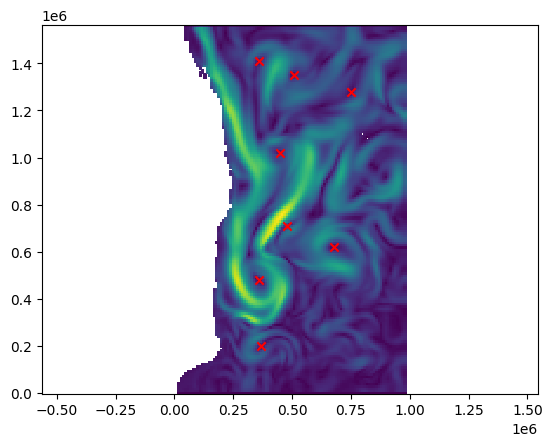

In [85]:
plt.pcolor(X, Y, np.hypot(u0, v0).T)

plt.scatter(nxc, nyc, color='r', marker='x')
plt.axis('equal')

(np.float64(147.02587648296102),
 np.float64(162.19693802096765),
 np.float64(-41.5791631412529),
 np.float64(-25.074123716396024))

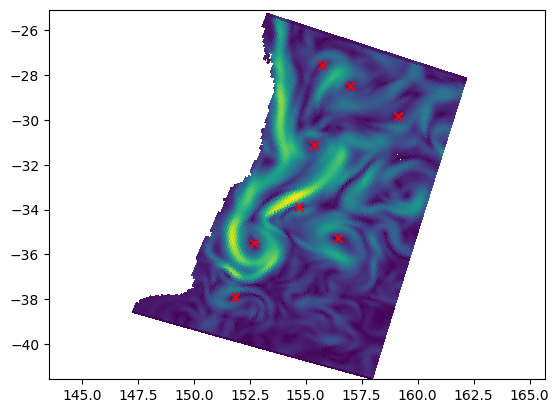

In [86]:
plt.pcolor(lon, lat, np.hypot(u0, v0))

plt.scatter(nlon, nlat, color='r', marker='x')
plt.axis('equal')



(np.float64(-5000.0),
 np.float64(985000.0),
 np.float64(-5000.0),
 np.float64(1565000.0))

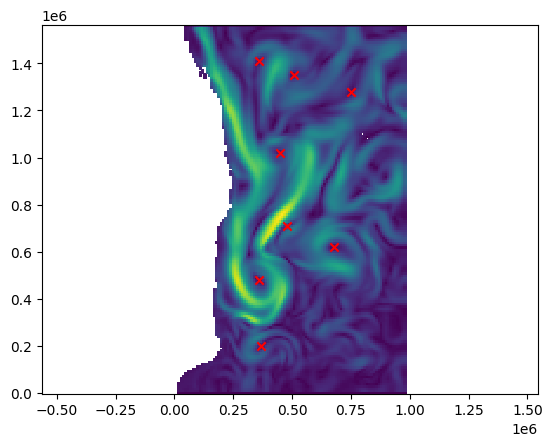

In [87]:
plt.pcolor(X, Y, np.hypot(u0, v0).T)

plt.scatter(X[nic, njc], Y[nic, njc], color='r', marker='x')
plt.axis('equal')

In [83]:
y_new[-1]

np.float64(1560000.0)

In [110]:
df = pd.DataFrame(columns=['Eddy', 'Day', 'Cyc', 'nLon', 'nLat', 'nxc', 'nyc', 'nic', 'njc'])

for t in range(NUM_DAYS):
    u0, v0 = u[:, :, t], v[:, :, t]
    neddy = nencioli(u0.T, v0.T, X, Y, 4, 3)[2]
    neddy = neddy[neddy[:, 1].argsort()[::-1]]

    BDRY_DIST = 150000
    neddy = neddy[
        (neddy[:, 0] <= x_new[-1] - BDRY_DIST) &
        (neddy[:, 1] >= BDRY_DIST) &
        (neddy[:, 1] <= y_new[-1] - BDRY_DIST)
    ]
    
    nic, njc = np.array([], dtype=int), np.array([], dtype=int)
    for nxc0, nyc0 in zip(neddy[:, 0], neddy[:, 1]):
        nic0, njc0 = np.where((X == nxc0) & (Y == nyc0))
        nic = np.append(nic, nic0)
        njc = np.append(njc, njc0)
    
    nlon, nlat = lon.T[nic, njc], lat.T[nic, njc]

    df = pd.concat([
        df,
        pd.DataFrame({
            'Eddy': np.arange(len(neddy)),
            'Day': t,
            'Cyc': np.where(neddy[:, 2] == 1, 'CE', 'AE'),
            'nLon': nlon,
            'nLat': nlat,
            'nxc': neddy[:, 1],
            'nyc': neddy[:, 0],
            'nic': nic,
            'njc': njc
        })
    ], ignore_index=True)



/scratch/pbs.6172889.kman.restech.unsw.edu.au/ipykernel_142795/3265515174.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([


In [111]:
df

,Eddy,Day,Cyc,nLon,nLat,nxc,nyc,nic,njc
0,0,0,CE,155.750612,-27.524102,1410000.0,360000.0,141,36
1,1,0,AE,156.999938,-28.499504,1350000.0,510000.0,135,51
2,2,0,CE,159.116876,-29.837949,1280000.0,750000.0,128,75
3,3,0,CE,155.373975,-31.138124,1020000.0,450000.0,102,45
4,4,0,AE,154.680294,-33.886031,710000.0,480000.0,71,48
...,...,...,...,...,...,...,...,...,...
376,9,29,AE,158.113579,-35.105463,690000.0,820000.0,69,82
377,10,29,CE,155.731675,-35.058242,620000.0,610000.0,62,61
378,11,29,CE,152.061104,-35.591493,450000.0,310000.0,45,31
379,12,29,AE,156.441962,-36.971906,440000.0,730000.0,44,73


,Eddy,Day,Cyc,nLon,nLat,nxc,nyc,nic,njc
0,0,0,CE,155.750612,-27.524102,1410000.0,360000.0,141,36
1,1,0,AE,156.999938,-28.499504,1350000.0,510000.0,135,51
2,2,0,CE,159.116876,-29.837949,1280000.0,750000.0,128,75
3,3,0,CE,155.373975,-31.138124,1020000.0,450000.0,102,45
4,4,0,AE,154.680294,-33.886031,710000.0,480000.0,71,48
5,5,0,CE,156.456920,-35.274009,620000.0,680000.0,62,68
6,6,0,CE,152.684269,-35.488257,480000.0,360000.0,48,36
7,7,0,CE,151.831975,-37.922289,200000.0,370000.0,20,37


nan
nan
nan
nan
nan
nan
nan
nan


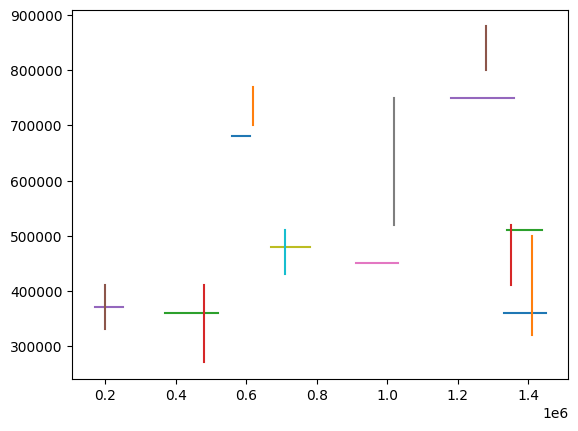

In [156]:
for _, reddy in df[df['Day'] == 0].iterrows():
    u_rel, v_rel = u[:,:,reddy['Day']].T, v[:,:,reddy['Day']].T
    u1, v1 = u_rel[:, reddy['njc']].squeeze(), v_rel[:, reddy['njc']].squeeze()
    u2, v2 = u_rel[reddy['nic'], :].squeeze(), v_rel[reddy['nic'], :].squeeze()
    cyc = 'CE' if reddy['Cyc'] == 1 else 'AE'

    xc, yc, xx, yy, w = moca(u1, v1, u2, v2, reddy['nic'], reddy['njc'], res, cyc)
    
    xc, yc = xc + reddy['nxc'], yc + reddy['nyc']
    
    print(xc)
    plt.scatter(xc, yc)
    plt.plot(reddy['nxc'] + xx, [reddy['nyc']] * len(xx))
    plt.plot([reddy['nxc']] * len(yy), reddy['nyc'] + yy)

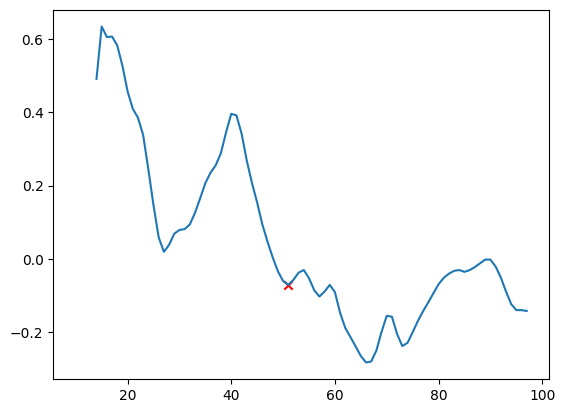

In [145]:
plt.plot(vector)
plt.scatter(51, vector[51], marker='x', color='r')

In [141]:
reddy['njc']

51

In [34]:
df

,Eddy,Day,Cyc,nLon,nLat,nxc,nyc,njc,nic
0,0,0,AE,161.100654,-29.708585,930.0,1360.0,93,136
1,1,0,AE,158.710995,-36.785528,920.0,530.0,92,53
2,2,0,CE,159.581912,-33.381462,900.0,920.0,90,92
3,3,0,AE,158.584376,-35.057335,860.0,710.0,86,71
4,4,0,CE,160.775291,-28.094182,850.0,1520.0,85,152
...,...,...,...,...,...,...,...,...,...
505,14,29,AE,156.292419,-27.794549,420.0,1400.0,42,140
506,15,29,CE,154.944476,-30.812784,400.0,1040.0,40,104
507,16,29,CE,152.061104,-35.591493,310.0,450.0,31,45
508,17,29,CE,150.438485,-38.964233,290.0,50.0,29,5


In [28]:
df.loc[df['Day']==0]

,Eddy,Day,Cyc,Lon,Lat,x,y
0,0,0,AE,161.100654,-29.708585,930.0,1360.0
1,1,0,AE,158.710995,-36.785528,920.0,530.0
2,2,0,CE,159.581912,-33.381462,900.0,920.0
3,3,0,AE,158.584376,-35.057335,860.0,710.0
4,4,0,CE,160.775291,-28.094182,850.0,1520.0
5,5,0,CE,159.116876,-29.837949,750.0,1280.0
6,6,0,CE,156.456920,-35.274009,680.0,620.0
7,7,0,AE,153.099338,-39.618097,530.0,60.0
8,8,0,AE,156.999938,-28.499504,510.0,1350.0
9,9,0,AE,154.680294,-33.886031,480.0,710.0


In [ ]:
def eddy_tracking(daydic):

    DAYS_TO_LOOK_BACK = 5
    VORT_WEIGHT = .5*1E9
    R_THRESH = .5

    next_num = max(list(range(1,daydic['Day1'].shape[0])))+1
    for day in range(2, len(daydic)+1):
        ddata_pre = daydic['Day'+str(day-1)]
        ddata_post = daydic['Day'+str(day)]
        pre_C_lon  = ddata_pre.Clon
        pre_C_lat  = ddata_pre.Clat
        post_C_lon  = ddata_post.Clon
        post_C_lat  = ddata_post.Clat
        pre_vort  = ddata_pre.Vort
        post_vort  = ddata_post.Vort
        eID = np.full(len(post_C_lon), np.nan)
        for j in range(len(post_C_lon)):
            for i in range(len(pre_C_lon)):
                R = np.sqrt((pre_C_lon.iloc[i] - post_C_lon.iloc[j])**2 + (pre_C_lat.iloc[i] - post_C_lat.iloc[j])**2 + VORT_WEIGHT*(pre_vort.iloc[i]-post_vort.iloc[j])**2)
                if R < R_THRESH and not any(eID == ddata_pre.iloc[i].ID):
                    eID[j] = int(ddata_pre.iloc[i].ID)
            for back_check in range(2, DAYS_TO_LOOK_BACK):
                if np.isnan(eID[j]) and day > back_check:
                    pre_C_lon = daydic['Day'+str(day-back_check)].Clon
                    pre_C_lat = daydic['Day'+str(day-back_check)].Clat
                    pre_vort = daydic['Day'+str(day-back_check)].Vort
                    for i in range(len(pre_C_lat)):
                        R = np.sqrt((pre_C_lon.iloc[i] - post_C_lon.iloc[j])**2 + (pre_C_lat.iloc[i] - post_C_lat.iloc[j])**2 + VORT_WEIGHT*(pre_vort.iloc[i]-post_vort.iloc[j])**2)
                        if R < R_THRESH and not any(eID == daydic['Day'+str(day-back_check)].iloc[i].ID):
                            eID[j] = int(daydic['Day'+str(day-back_check)].iloc[i].ID)
            ddata_pre = daydic['Day'+str(day-1)]
            pre_C_lon  = ddata_pre.Clon
            pre_C_lat  = ddata_pre.Clat
            pre_vort = ddata_pre.Vort
            if np.isnan(eID[j]):
                eID[j] = next_num
                next_num += 1
        eID = [round(x) for x in eID]
        ddata_post = daydic['Day'+str(day)]
        ddata_post.ID = eID
        ddata_post.index = ['Eddy' + str(i) for i in eID]
    
    return daydic